In [3]:
pip install torch

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


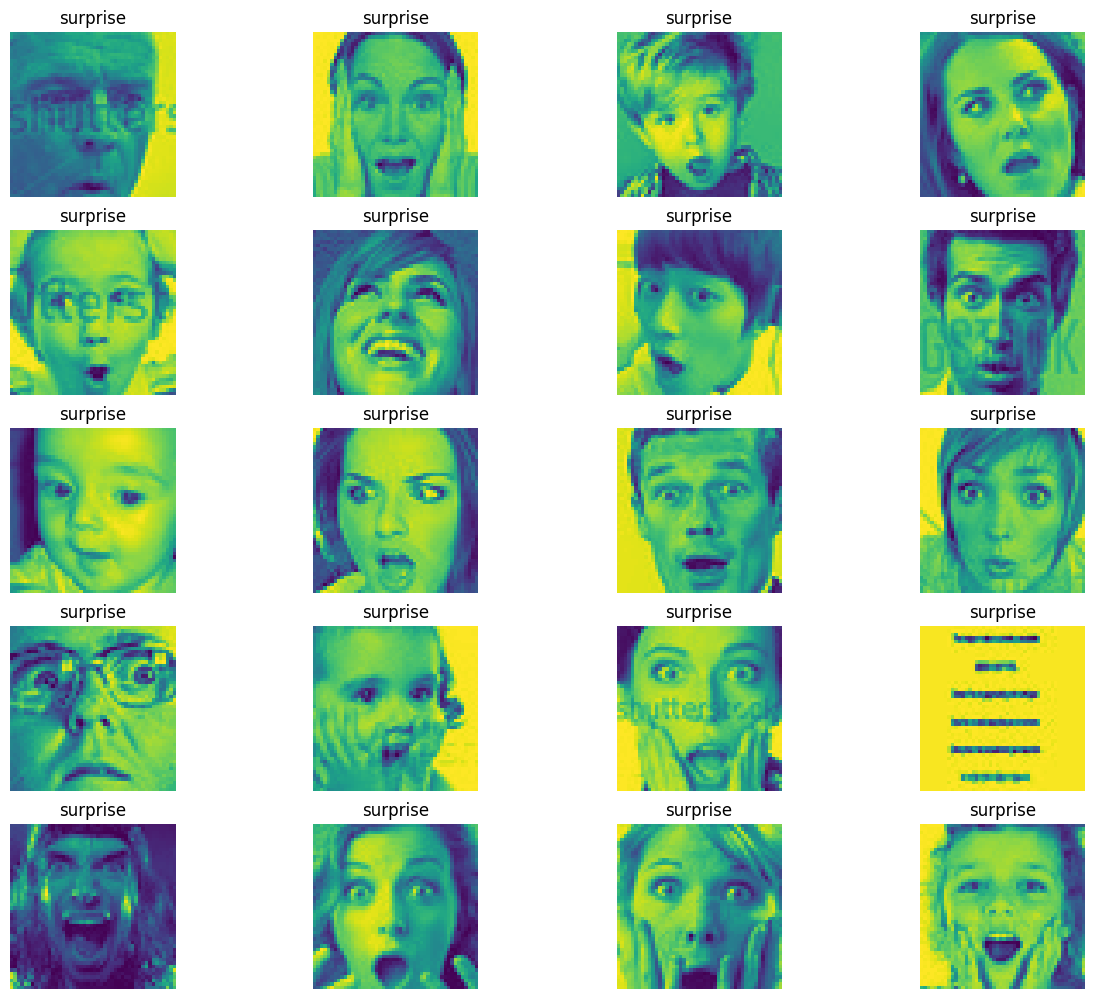

In [4]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def show_images(directory, num_samples=20, cols=4):
    """ Plots some samples from the directory """
    plt.figure(figsize=(15,15)) 
    folders = os.listdir(directory)
    for folder in folders:
        imgs = os.listdir(os.path.join(directory, folder))
        for i, img_name in enumerate(imgs):
            if i == num_samples:
                break
            img_path = os.path.join(directory, folder, img_name)
            img = Image.open(img_path)
            plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
            plt.imshow(img)
            plt.title(folder)  # Display folder name as title
            plt.axis('off')     # Turn off axis
show_images("/home/banand_umassd_edu/FER2013/train")

In [5]:
import torch.nn.functional as F
import torch
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

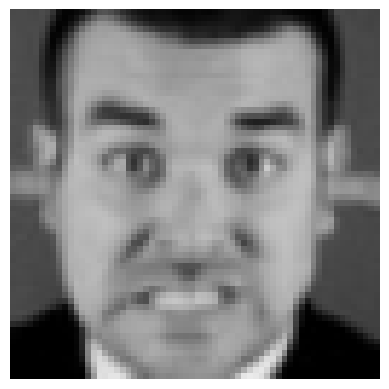

In [6]:
import torch
from torchvision import transforms 
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = 64
BATCH_SIZE = 128

def load_transformed_dataset(train_directory, test_directory):
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t * 2) - 1)
    ]
    data_transform = transforms.Compose(data_transforms)

    train_dataset = ImageFolder(root=train_directory, transform=data_transform)
    test_dataset = ImageFolder(root=test_directory, transform=data_transform)

    # Concatenate train and test datasets
    dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])
    return dataset

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))
    plt.axis('off')
    plt.show()

# Assuming your train dataset is located at "/kaggle/input/fer2013/train" 
# and test dataset is located at "/kaggle/input/fer2013/test"
train_data_directory = "/home/banand_umassd_edu/FER2013/train"
test_data_directory = "/home/banand_umassd_edu/FER2013/test"
data = load_transformed_dataset(train_data_directory, test_data_directory)
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# Test loading and displaying an image
for batch in dataloader:
    images, _ = batch
    show_tensor_image(images)
    break  # Break after showing one batch of images


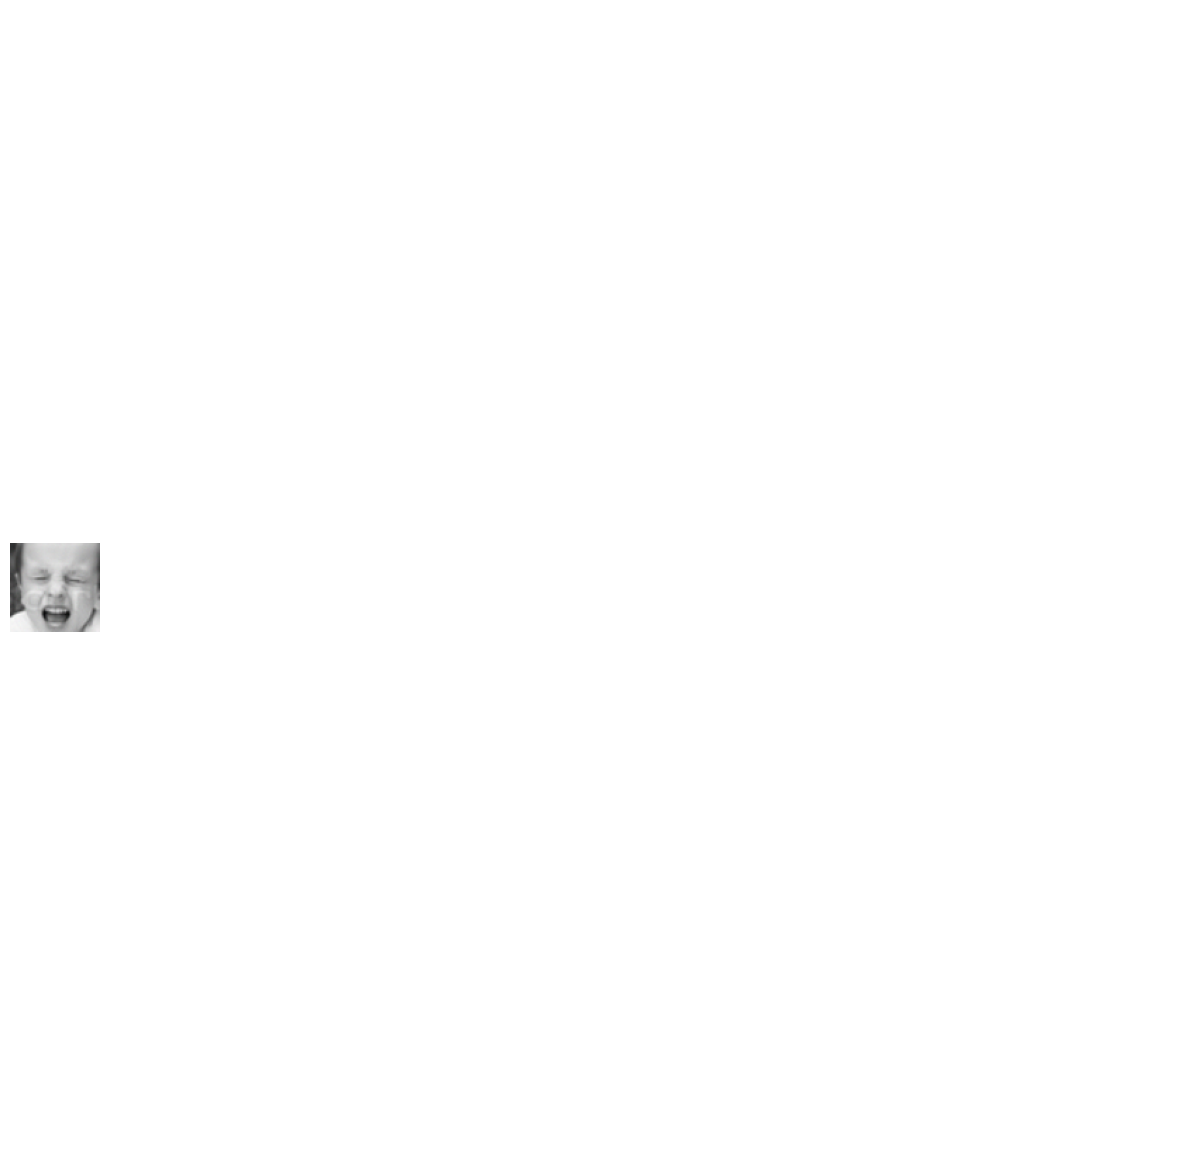

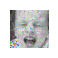

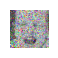

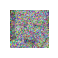

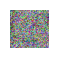

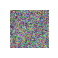

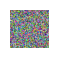

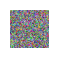

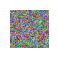

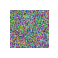

In [7]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

In [8]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        
        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor

In [9]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [10]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 


In [12]:
# Save the last 10 generated images in larger size
#sample_plot_image(epochs - 1, save_large=True)


Epoch 0 | Average Loss: 0.2263
Shape of the tensor after selecting the last image: torch.Size([3, 64, 64])


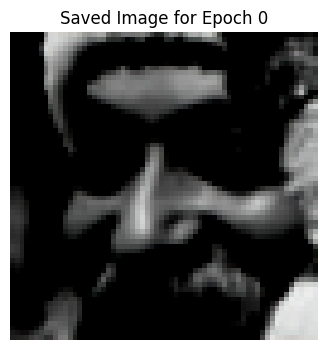

Epoch 1 | Average Loss: 0.1397
Shape of the tensor after selecting the last image: torch.Size([3, 64, 64])


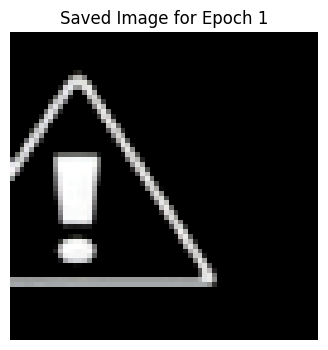

Epoch 2 | Average Loss: 0.1286
Shape of the tensor after selecting the last image: torch.Size([3, 64, 64])


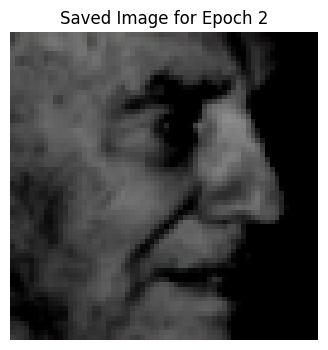

Epoch 3 | Average Loss: 0.1244
Shape of the tensor after selecting the last image: torch.Size([3, 64, 64])


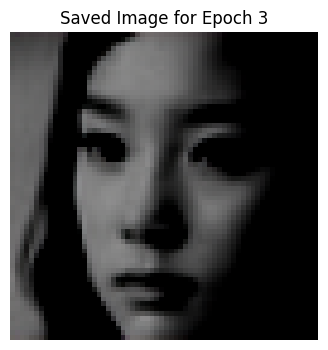

Epoch 4 | Average Loss: 0.1195
Shape of the tensor after selecting the last image: torch.Size([3, 64, 64])


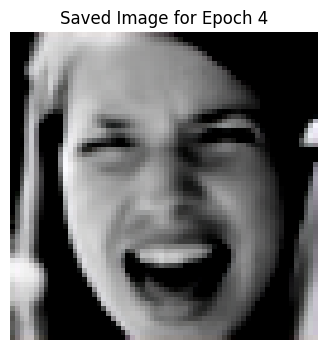

Epoch 5 | Average Loss: 0.1138
Shape of the tensor after selecting the last image: torch.Size([3, 64, 64])


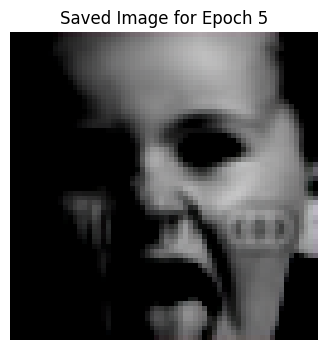

Epoch 6 | Average Loss: 0.1101
Shape of the tensor after selecting the last image: torch.Size([3, 64, 64])


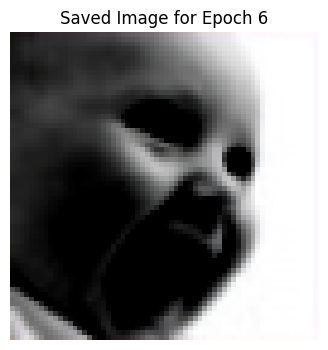

Epoch 7 | Average Loss: 0.1084
Shape of the tensor after selecting the last image: torch.Size([3, 64, 64])


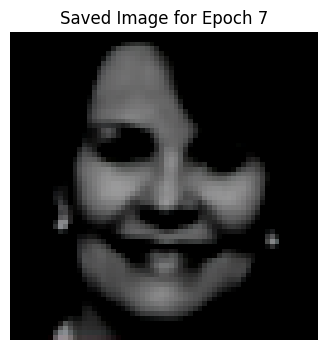

Epoch 8 | Average Loss: 0.1064
Shape of the tensor after selecting the last image: torch.Size([3, 64, 64])


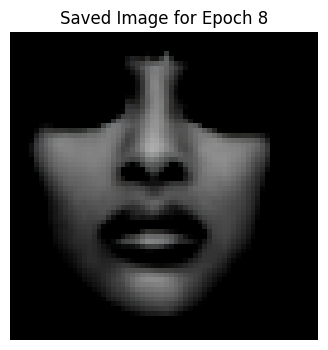

Epoch 9 | Average Loss: 0.1050
Shape of the tensor after selecting the last image: torch.Size([3, 64, 64])


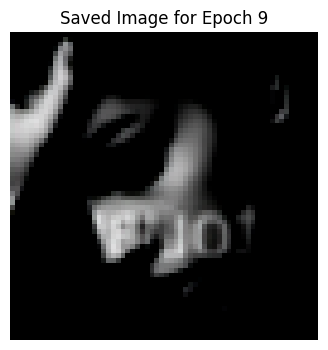

Epoch 10 | Average Loss: 0.1047
Shape of the tensor after selecting the last image: torch.Size([3, 64, 64])


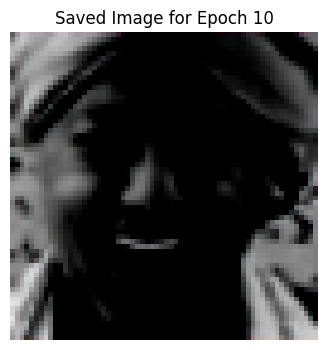

Epoch 11 | Average Loss: 0.1035
Shape of the tensor after selecting the last image: torch.Size([3, 64, 64])


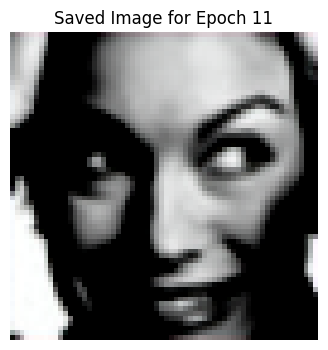

Epoch 12 | Average Loss: 0.1027
Shape of the tensor after selecting the last image: torch.Size([3, 64, 64])


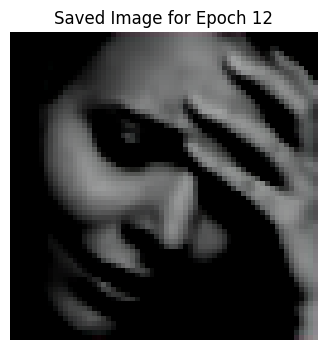

Epoch 13 | Average Loss: 0.1024
Shape of the tensor after selecting the last image: torch.Size([3, 64, 64])


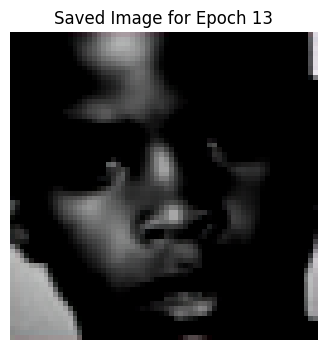

Epoch 14 | Average Loss: 0.1027
Shape of the tensor after selecting the last image: torch.Size([3, 64, 64])


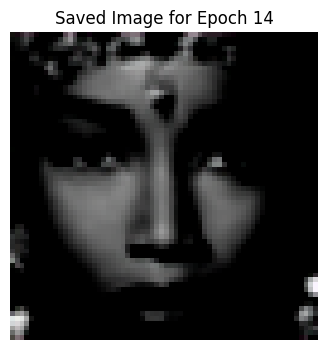

Epoch 15 | Average Loss: 0.1020
Shape of the tensor after selecting the last image: torch.Size([3, 64, 64])


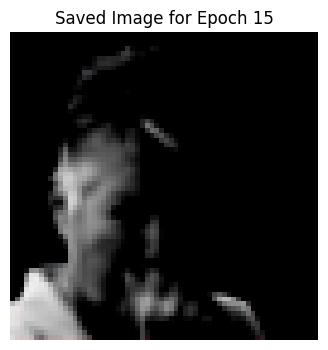

Epoch 16 | Average Loss: 0.1016
Shape of the tensor after selecting the last image: torch.Size([3, 64, 64])


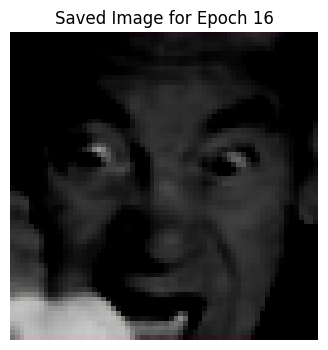

Epoch 17 | Average Loss: 0.1008
Shape of the tensor after selecting the last image: torch.Size([3, 64, 64])


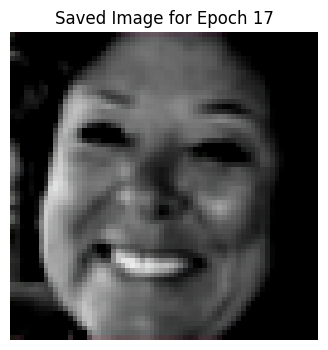

Epoch 18 | Average Loss: 0.1007
Shape of the tensor after selecting the last image: torch.Size([3, 64, 64])


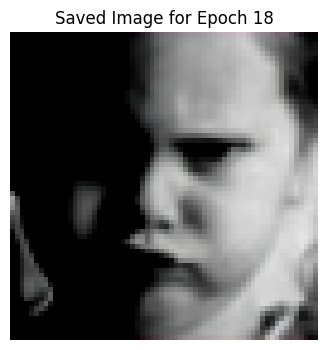

Epoch 19 | Average Loss: 0.1000
Shape of the tensor after selecting the last image: torch.Size([3, 64, 64])


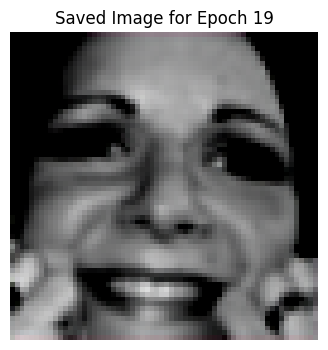

Epoch 20 | Average Loss: 0.1004
Shape of the tensor after selecting the last image: torch.Size([3, 64, 64])


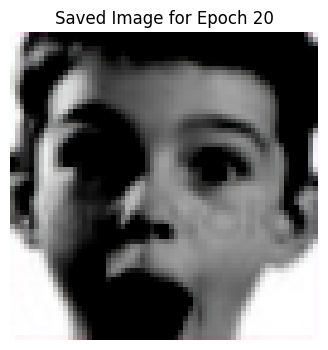

Epoch 21 | Average Loss: 0.0997
Shape of the tensor after selecting the last image: torch.Size([3, 64, 64])


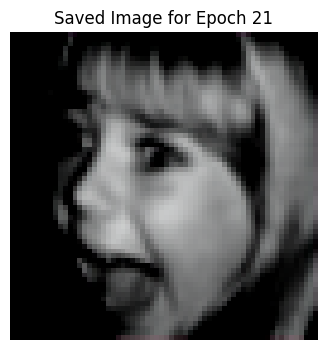

Epoch 22 | Average Loss: 0.0996
Shape of the tensor after selecting the last image: torch.Size([3, 64, 64])


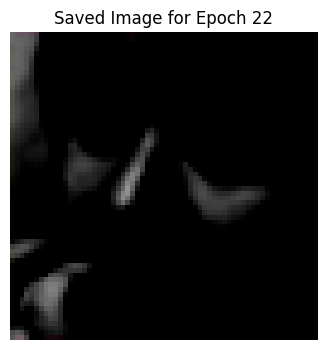

Epoch 23 | Average Loss: 0.1000
Shape of the tensor after selecting the last image: torch.Size([3, 64, 64])


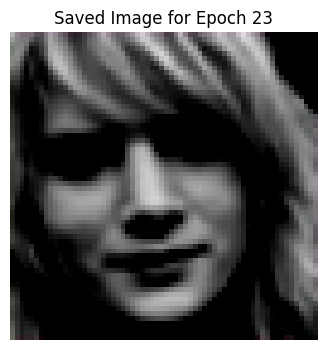

Epoch 24 | Average Loss: 0.0996
Shape of the tensor after selecting the last image: torch.Size([3, 64, 64])


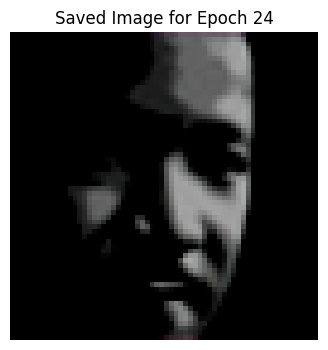

Epoch 25 | Average Loss: 0.0997
Shape of the tensor after selecting the last image: torch.Size([3, 64, 64])


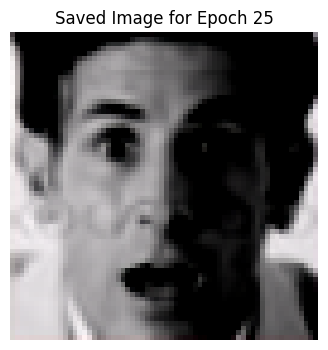

Epoch 26 | Average Loss: 0.0989
Shape of the tensor after selecting the last image: torch.Size([3, 64, 64])


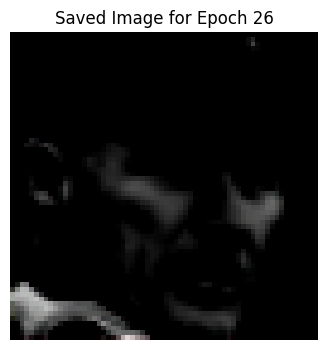

Epoch 27 | Average Loss: 0.0990
Shape of the tensor after selecting the last image: torch.Size([3, 64, 64])


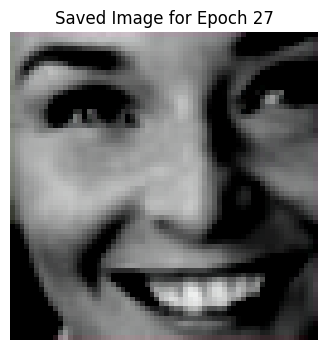

Epoch 28 | Average Loss: 0.0981
Shape of the tensor after selecting the last image: torch.Size([3, 64, 64])


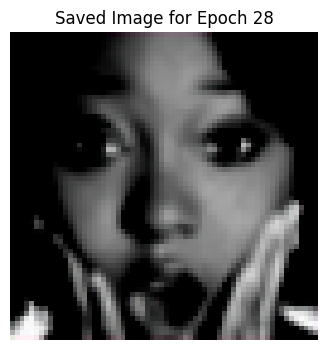

Epoch 29 | Average Loss: 0.0986
Shape of the tensor after selecting the last image: torch.Size([3, 64, 64])


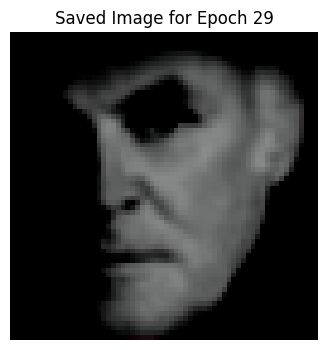

Epoch 30 | Average Loss: 0.0982
Shape of the tensor after selecting the last image: torch.Size([3, 64, 64])


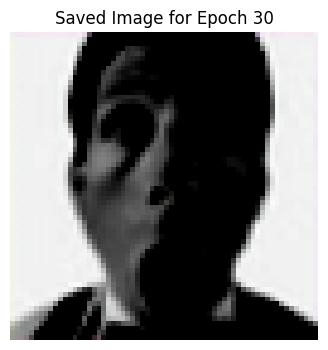

Epoch 31 | Average Loss: 0.0985
Shape of the tensor after selecting the last image: torch.Size([3, 64, 64])


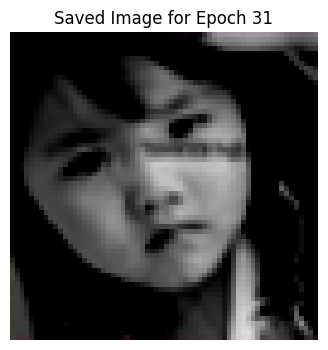

Epoch 32 | Average Loss: 0.0982
Shape of the tensor after selecting the last image: torch.Size([3, 64, 64])


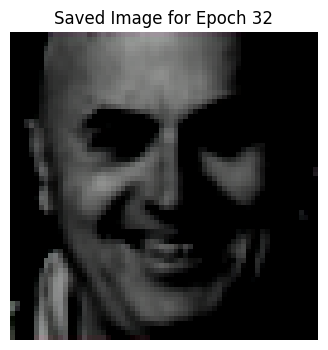

Epoch 33 | Average Loss: 0.0980
Shape of the tensor after selecting the last image: torch.Size([3, 64, 64])


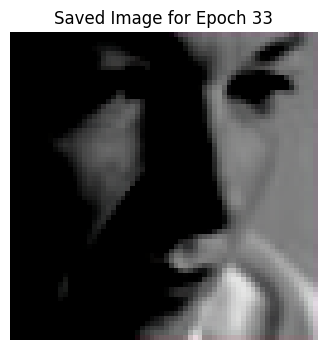

Epoch 34 | Average Loss: 0.0976
Shape of the tensor after selecting the last image: torch.Size([3, 64, 64])


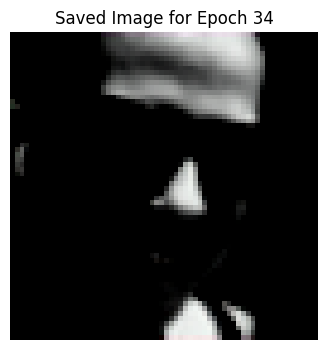

Epoch 35 | Average Loss: 0.0976
Shape of the tensor after selecting the last image: torch.Size([3, 64, 64])


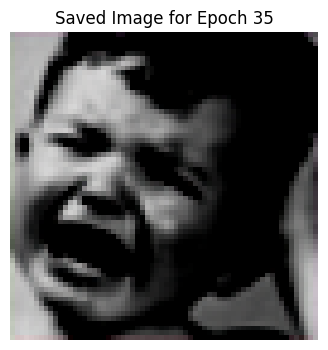

Epoch 36 | Average Loss: 0.0980
Shape of the tensor after selecting the last image: torch.Size([3, 64, 64])


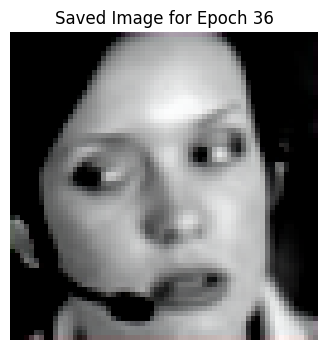

Epoch 37 | Average Loss: 0.0976
Shape of the tensor after selecting the last image: torch.Size([3, 64, 64])


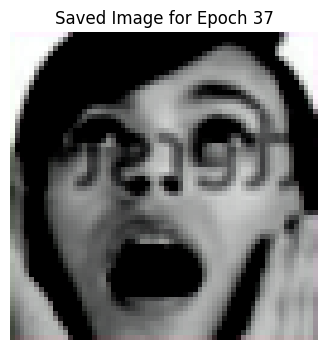

Epoch 38 | Average Loss: 0.0975
Shape of the tensor after selecting the last image: torch.Size([3, 64, 64])


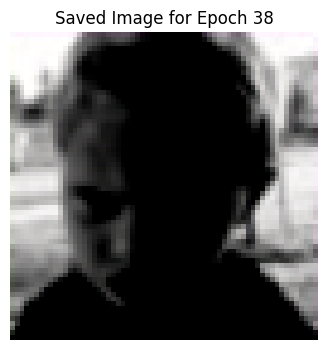

Epoch 39 | Average Loss: 0.0974
Shape of the tensor after selecting the last image: torch.Size([3, 64, 64])


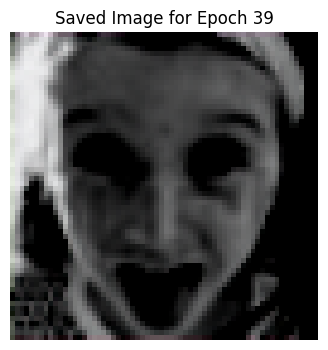

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from torch.optim import Adam

# Create a directory to save the images if it doesn't exist
save_dir = "denoised_images"
os.makedirs(save_dir, exist_ok=True)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 1000 

# Training loop
for epoch in range(epochs):
    epoch_loss = 0.0  # Initialize loss for the epoch
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()
        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        loss = get_loss(model, batch[0], t)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()  # Accumulate the loss

    # Average the loss over all steps and print it
    epoch_loss /= len(dataloader)
    print(f"Epoch {epoch} | Average Loss: {epoch_loss:.4f}")

    # At the end of each epoch, process and save the last image
    with torch.no_grad():
        img = batch[0].to(device)
        img_t = sample_timestep(img, torch.tensor([0], device=device))  # t=0 for the final image

        # Select the last image from the batch
        if img_t.dim() == 4 and img_t.shape[0] > 1:
            img_t = img_t[-1]  

        # Print the shape of the tensor to confirm it is now [C, H, W]
        print(f"Shape of the tensor after selecting the last image: {img_t.shape}")

        # Clamp the image tensor to the valid range of pixel values
        img_t = torch.clamp(img_t, 0, 1)

        # Save the image tensor to a file
        save_path = os.path.join(save_dir, f"last_image_epoch_{epoch}.png")
        save_image(img_t, save_path)

        # Display the saved image
        saved_img = plt.imread(save_path)
        plt.figure(figsize=(4, 4))
        plt.imshow(saved_img)
        plt.title(f"Saved Image for Epoch {epoch}")
        plt.axis('off')
        plt.show()
